# 1. Vital Sign Waveform Extraction

In [ ]:
# Step 1: Heartbeat Waveform Extraction for 1-minute mmWave recording
import numpy as np
from scipy.signal import sosfiltfilt, butter
from numpy.fft import rfft, fftshift
from sklearn.decomposition import PCA

# ----------------------------
# CONFIG — EDIT THESE VALUES
# ----------------------------
# data_cube shape: (n_frames, n_chirps_per_frame, n_samples_per_chirp, n_antennas)
# Example: data_cube = np.load('your_cube.npy')
CENTER_FREQ_HZ = 60e9        # center frequency (Hz) — set to your radar's carrier (e.g., 60e9)
DURATION_SECONDS = 62.0      # actual recording duration (seconds). Set to 61 if GT CSV runs 61s.
TARGET_RANGE_BIN = None      # set to integer if you know it; otherwise auto-detected

HEART_BAND = (0.8, 2.0)      # bandpass (Hz) for heartbeat (default 0.8–4 Hz)
BREATH_BAND = (0.1, 0.6)
"""
#reference 1
        br_band = (0.1, 0.6)   # breathing
        hr_band = (0.8, 2.0)   # heart
"""


IIR_ORDER = 4                # total filter order (even number recommended) -> uses SOS (biquad cascade)
ANTENNA_FUSION = 'mean'      # 'mean' or 'pca' or 'none' (per-antenna outputs)
SPEED_OF_LIGHT = 299792458.0

# ----------------------------
# FUNCTIONS
# ----------------------------
def compute_range_profile(data_cube):
    """
    Collapse chirps per frame and perform range FFT.
    Input shape: (n_frames, n_chirps, n_samples, n_antennas)
    Output shape: (n_frames, n_range_bins, n_antennas), complex values
    """
    # Coherently average chirps per frame (sum or mean across chirps)
    # This preserves phase. Use mean to normalize.
    frames_mean = np.mean(data_cube, axis=1)  # shape -> (n_frames, n_samples, n_antennas)
    # Range FFT (real->complex). Use rfft to get positive freq bins if desired.
    # We'll use rfft for efficiency; this yields n_samples//2+1 bins.
    n_frames, n_samples, n_antennas = frames_mean.shape
    # Perform FFT along the sample axis for each antenna
    range_profiles = np.empty((n_frames, n_samples//2 + 1, n_antennas), dtype=np.complex64)
    for a in range(n_antennas):
        range_profiles[:, :, a] = rfft(frames_mean[:, :, a], axis=1)
    return range_profiles

def auto_select_range_bin(range_profiles):
    """
    Pick the range bin index with largest average magnitude across frames and antennas.
    Input shape: (n_frames, n_bins, n_antennas)
    """
    mag = np.abs(range_profiles)  # (frames, bins, ants)
    avg_mag_over_time_and_ant = mag.mean(axis=(0, 2))  # shape (n_bins,)
    return int(np.argmax(avg_mag_over_time_and_ant))

def phase_to_displacement(phase_unwrapped, center_freq_hz):
    """
    Convert unwrapped phase (radians) to displacement (meters).
    For round-trip radar, delta_phase --> delta_range = (lambda / (4 * pi)) * delta_phase
    lambda = c / f_c
    """
    lam = SPEED_OF_LIGHT / center_freq_hz
    disp = phase_unwrapped * (lam / (4.0 * np.pi))
    return disp

def biquad_bandpass_sos(fs, lowcut, highcut, order=4):
    """
    Create SOS (second-order sections) bandpass Butterworth (biquad cascade) filter.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(N=order, Wn=[low, high], btype='bandpass', output='sos')
    return sos



def load_mmwave_bin_to_datacube(bin_path,
                                num_antennas=4,
                                num_samples_per_chirp=250,
                                num_chirps_per_frame=128,
                                num_frames=1200,
                                dtype=np.int16):
    """
    Load raw mmWave .bin file and convert to 4D data cube:
    (n_frames, n_chirps_per_frame, n_samples_per_chirp, n_antennas)

    Parameters:
    - bin_path: str, path to .bin file
    - num_antennas: int, number of antennas in radar
    - num_samples_per_chirp: int, samples per chirp
    - num_chirps_per_frame: int, chirps per frame
    - num_frames: int, total frames
    - dtype: data type to read from file (default int16)

    Returns:
    - data_cube: np.ndarray, complex64, shape as above
    """
    raw_data = np.fromfile(bin_path, dtype=dtype)

    if raw_data.size % 2 != 0:
        raise ValueError("File length not even — likely wrong dtype or incomplete file")

    complex_data = raw_data[::2] + 1j * raw_data[1::2]

    expected_size = num_frames * num_chirps_per_frame * num_samples_per_chirp * num_antennas
    if complex_data.size != expected_size:
        raise ValueError(f"Data size mismatch! Expected {expected_size}, got {complex_data.size}")

    data_cube = complex_data.reshape(
        num_frames,
        num_chirps_per_frame,
        num_samples_per_chirp,
        num_antennas
    )

    return data_cube

def extract_breath_waveforms(data_cube,
                                center_freq_hz=CENTER_FREQ_HZ,
                                duration_seconds=DURATION_SECONDS,
                                target_range_bin=TARGET_RANGE_BIN,
                                breath_band=BREATH_BAND,
                                iir_order=IIR_ORDER,
                                antenna_fusion=ANTENNA_FUSION):
    """
    Main wrapper to extract heartbeat waveform(s) from a data cube.
    Returns:
      - t: time vector (n_frames,)
      - filtered: if antenna_fusion == 'none' -> shape (n_antennas, n_frames)
                  else -> shape (n_frames,) fused single signal
      - raw_disp: raw displacement (before filtering) per antenna (n_antennas, n_frames)
    """
    # Shapes and sampling
    n_frames, n_chirps, n_samples, n_antennas = data_cube.shape
    fs = n_frames / float(duration_seconds)  # frames per second (temporal sampling rate)
    t = np.arange(n_frames) / fs

    # 1) Range profiles
    range_profiles = compute_range_profile(data_cube)  # (n_frames, n_bins, n_antennas)
    n_bins = range_profiles.shape[1]

    # 2) Choose target range bin
    if target_range_bin is None:
        target_bin = auto_select_range_bin(range_profiles)
        print(f"[auto] selected target_range_bin = {target_bin}")
    else:
        target_bin = int(target_range_bin)
        if target_bin < 0 or target_bin >= n_bins:
            raise ValueError("target_range_bin out of range")
        print(f"[user] using target_range_bin = {target_bin}")

    # 3) Extract phase across frames for each antenna and unwrap
    raw_phase = np.angle(range_profiles[:, target_bin, :])  # shape (n_frames, n_antennas)
    raw_phase_unwrapped = np.unwrap(raw_phase, axis=0)

    # 4) Convert phase -> displacement
    # keyed by antenna: shape (n_frames, n_antennas) -> transpose to (n_antennas, n_frames)
    disp_by_ant = phase_to_displacement(raw_phase_unwrapped.T, center_freq_hz)  # shape (n_antennas, n_frames)

    # 5) Biquad cascade IIR (bandpass) via sosfiltfilt
    sos = biquad_bandpass_sos(fs, breath_band[0], breath_band[1], order=iir_order)
    filtered_by_ant = np.empty_like(disp_by_ant)
    for a in range(disp_by_ant.shape[0]):
        # Use filtfilt-like zero-phase filtering via sosfiltfilt
        filtered_by_ant[a, :] = sosfiltfilt(sos, disp_by_ant[a, :])

    # 6) Antenna fusion
    if antenna_fusion == 'mean':
        fused = filtered_by_ant.mean(axis=0)
        output = fused
    elif antenna_fusion == 'pca':
        # Use PCA on the (n_frames x n_antennas) matrix -> take first PC
        pca = PCA(n_components=1)
        out = pca.fit_transform(filtered_by_ant.T).squeeze()  # shape (n_frames,)
        output = out
    elif antenna_fusion == 'none':
        output = filtered_by_ant  # shape (n_antennas, n_frames)
    else:
        raise ValueError("antenna_fusion must be 'mean', 'pca', or 'none'")

    return t, output, disp_by_ant, filtered_by_ant


In [ ]:
data_cube = load_mmwave_bin_to_datacube('/Users/malakzriouli/Downloads/4tu_data/Human_Vital_Signs_Detection/Radar data/Participant 1/1. Distance Scenario/40 cm/1/data_Raw_0.bin'  # <--- change this
)
data_cube.shape


(1200, 128, 250, 4)

[auto] selected target_range_bin = 44


/Users/malakzriouli/opt/anaconda3/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


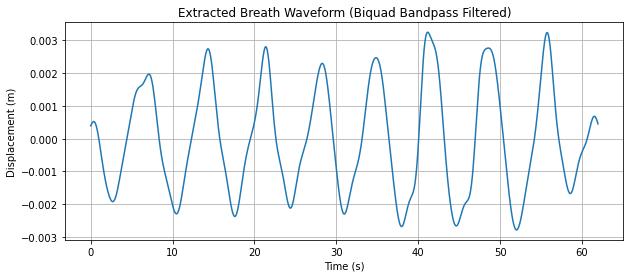

In [ ]:
import matplotlib.pyplot as plt

t, breath_sig, raw_disp_by_ant, filtered_by_ant = extract_breath_waveforms(data_cube)

plt.figure(figsize=(10, 4))
plt.plot(t, breath_sig)
plt.title("Extracted Breath Waveform (Biquad Bandpass Filtered)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid(True)
plt.show()


### Extracting all files' directories

In [ ]:

import os
import re
import pandas as pd

root_dir = "/Volumes/SAMSUNG/Dataset/Human/Radar data"
save_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_rate_manifest.csv"

# --------------------------
# CUSTOM ORDER FOR EACH SCENARIO
# --------------------------
distance_order = ["40 cm", "80 cm", "120 cm", "160 cm"]
orientation_order = ["80 cm- back", "80 cm- Front side", "80 cm- left side", "80 cm- Right side"]
angle_order = ["0 deg- 80 cm", "30 deg- 80 cm", "45 deg- 80 cm"]
elevated_order = ["80 cm"]

rows = []

def normalize(text):
    #Remove spaces, lowercase, unify text for matching.
    return re.sub(r"\s+", "", text.lower())

def natural_key(s):
   #Natural sort key for numeric folder names.
    parts = re.split(r"(\d+)", s)
    return [int(p) if p.isdigit() else p.lower() for p in parts]

def sorted_dirs(path):
    if not os.path.isdir(path):
        return []
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    dirs.sort(key=natural_key)
    return dirs

def order_folders(target_order, candidates):

   # Reorder candidate folders according to the target order list.Matching is flexible ('80 cm' matches '80cm', etc.)

    ordered = []
    norm_map = {normalize(c): c for c in candidates}

    for target in target_order:
        nt = normalize(target)
        if nt in norm_map:
            ordered.append(norm_map[nt])
        else:
            # try matching numeric content if names vary
            digits = re.sub(r"\D", "", target)
            for cand in candidates:
                if digits in re.sub(r"\D", "", cand):
                    ordered.append(cand)
                    break

    # Add remaining folders not in custom order
    remaining = [c for c in candidates if c not in ordered]
    remaining.sort(key=natural_key)

    return ordered + remaining

for p in range(1, 11):

    participant_path = os.path.join(root_dir, f"Participant {p}")
    if not os.path.isdir(participant_path):
        continue

    scenario_dirs = sorted_dirs(participant_path)

    for scenario in scenario_dirs:
        scenario_path = os.path.join(participant_path, scenario)
        scenario_lower = scenario.lower()

        # --------------------------
        # CASE 1 — DISTANCE SCENARIO
        # --------------------------
        if "distance" in scenario_lower:
            level2 = sorted_dirs(scenario_path)
            ordered_level2 = order_folders(distance_order, level2)

        # --------------------------
        # CASE 2 — ORIENTATION SCENARIO
        # --------------------------
        elif "orientation" in scenario_lower:
            level2 = sorted_dirs(scenario_path)
            ordered_level2 = order_folders(orientation_order, level2)

        # --------------------------
        # CASE 3 — ANGLE SCENARIO
        # --------------------------
        elif "angle" in scenario_lower:
            level2 = sorted_dirs(scenario_path)
            ordered_level2 = order_folders(angle_order, level2)

        # --------------------------
        # CASE 4 — ELEVATED SCENARIO
        # --------------------------
        elif "elevated" in scenario_lower:
            level2 = sorted_dirs(scenario_path)
            ordered_level2 = order_folders(elevated_order, level2)

        # --------------------------
        # OTHER (unexpected)
        # --------------------------
        else:
            level2 = sorted_dirs(scenario_path)
            ordered_level2 = level2  # default sorted

        # Process each level2 folder (distance/angle/orientation/elevated)
        for folder in ordered_level2:
            folder_path = os.path.join(scenario_path, folder)

            recording_dirs = sorted_dirs(folder_path)  # 1,2,3,4

            for rec in recording_dirs:
                rec_path = os.path.join(folder_path, rec)

                for root, dirs, files in os.walk(rec_path):
                    files.sort()
                    if "data_Raw_0.bin" in files:
                        bin_path = os.path.join(root, "data_Raw_0.bin")

                        rows.append({
                            "participant": p,
                            "scenario": scenario,
                            "recording": rec,
                            "bin_path": bin_path,
                            "breathing_rate_gt": ""
                        })

# --------------------------
# SAVE CSV
# --------------------------
df = pd.DataFrame(rows, columns=[
    "participant",
    "scenario",
    "recording",
    "bin_path",
    "breathing_rate_gt"
])

os.makedirs(os.path.dirname(save_path), exist_ok=True)
df.to_csv(save_path, index=False)

print("CSV CREATED at:", save_path)
print("Total rows:", len(df))
print(df.head().to_string(index=False))


'\nimport os\nimport re\nimport pandas as pd\n\nroot_dir = "/Volumes/SAMSUNG/Dataset/Human/Radar data"\nsave_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_rate_manifest.csv"\n\n# --------------------------\n# CUSTOM ORDER FOR EACH SCENARIO\n# --------------------------\ndistance_order = ["40 cm", "80 cm", "120 cm", "160 cm"]\norientation_order = ["80 cm- back", "80 cm- Front side", "80 cm- left side", "80 cm- Right side"]\nangle_order = ["0 deg- 80 cm", "30 deg- 80 cm", "45 deg- 80 cm"]\nelevated_order = ["80 cm"]\n\nrows = []\n\ndef normalize(text):\n    #Remove spaces, lowercase, unify text for matching.\n    return re.sub(r"\\s+", "", text.lower())\n\ndef natural_key(s):\n   #Natural sort key for numeric folder names.\n    parts = re.split(r"(\\d+)", s)\n    return [int(p) if p.isdigit() else p.lower() for p in parts]\n\ndef sorted_dirs(path):\n    if not os.path.isdir(path):\n        return []\n    dirs = [d for d in os.listdir(path) if os.path.isd

### Adding the ground truth

In [ ]:

import pandas as pd
import ezodf

# Paths
csv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_rate_manifest.csv"
ods_path = "/Users/malakzriouli/Downloads/4tu_data/Human_Vital_Signs_Detection/BR_Ref_Values/BR_ref_human.ods"

# Orders for scenarios
distance_order = ["40 cm", "80 cm", "120 cm", "160 cm"]
orientation_order = ["80 cm- back", "80 cm- Front side", "80 cm- left side", "80 cm- Right side"]
angle_order = ["0 deg- 80 cm", "30 deg- 80 cm", "45 deg- 80 cm"]
elevated_order = ["80 cm"]

# Load the CSV manifest
df = pd.read_csv(csv_path)

# Load the ODS file
doc = ezodf.opendoc(ods_path)
sheet = doc.sheets[0]  # assuming the first sheet

# Function to read cell value safely
def cell_val(sheet, row, col):
    cell = sheet[row, col]
    return cell.value if cell.value is not None else None

# Parse ground truth data from ODS
# You'll have to inspect the ODS structure to correctly parse.
# For example, participant data starts at specific rows and columns.
# Based on the example you gave, let's try this approach:

def extract_ground_truth(sheet):
    ground_truths = []
    # Iterate over 10 participants
    for p in range(1, 11):
        # Find participant start row by searching for "Participant {p}" in first column
        start_row = None
        for r in range(sheet.nrows()):
            val = cell_val(sheet, r, 0)
            if val and f"Participant {p}" in str(val):
                start_row = r
                break
        if start_row is None:
            print(f"Participant {p} not found")
            continue

        # Now extract data for scenarios in order:

        # 1. Distance scenario: rows after start_row
        # Assuming fixed structure like your example,
        # distance data might be in rows start_row+2 to start_row+5 with cols M-1 to M-4
        # We'll average or take a single value for each distance? Probably average M1 to M4?

        for dist_i, dist in enumerate(distance_order):
            # Rows offset for distance data start (example based on your snippet)
            dist_row = start_row + 2 + dist_i
            # Average across M-1 to M-4 (columns maybe 3 to 6? Need to verify)
            vals = []
            for col in range(3, 7):  # M-1 to M-4 in example
                v = cell_val(sheet, dist_row, col)
                if v is not None:
                    vals.append(float(v))
            avg_val = sum(vals) / len(vals) if vals else None
            ground_truths.append(avg_val)

        # 2. Orientation scenario: rows for orientation after distance
        # Orientation data start at row start_row + 8 (example)
        for ori_i in range(1, 5):  # 4 orientations; assuming rows for left, right, back, front
            ori_row = start_row + 7 + ori_i  # rows 8-11 in example
            vals = []
            for col in range(3, 7):
                v = cell_val(sheet, ori_row, col)
                if v is not None:
                    vals.append(float(v))
            avg_val = sum(vals) / len(vals) if vals else None
            ground_truths.append(avg_val)

        # 3. Angle scenario: rows start_row + 13, 14 for 30 and 45 degrees
        for angle_i in range(1, 3):
            angle_row = start_row + 12 + angle_i
            vals = []
            for col in range(3, 7):
                v = cell_val(sheet, angle_row, col)
                if v is not None:
                    vals.append(float(v))
            avg_val = sum(vals) / len(vals) if vals else None
            ground_truths.append(avg_val)

        # 4. Elevated scenario - assuming single value at a specific row (example row start_row+16)
        elev_row = start_row + 16
        vals = []
        for col in range(3, 7):
            v = cell_val(sheet, elev_row, col)
            if v is not None:
                vals.append(float(v))
        avg_val = sum(vals) / len(vals) if vals else None
        ground_truths.append(avg_val)

    return ground_truths

br_ground_truth = extract_ground_truth(sheet)

# Add the ground truth to dataframe
df['BR_ground_truth'] = br_ground_truth

# Save updated CSV
df.to_csv(csv_path, index=False)
print("Added BR_ground_truth column and saved.")


'\nimport pandas as pd\nimport ezodf\n\n# Paths\ncsv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_rate_manifest.csv"\nods_path = "/Users/malakzriouli/Downloads/4tu_data/Human_Vital_Signs_Detection/BR_Ref_Values/BR_ref_human.ods"\n\n# Orders for scenarios\ndistance_order = ["40 cm", "80 cm", "120 cm", "160 cm"]\norientation_order = ["80 cm- back", "80 cm- Front side", "80 cm- left side", "80 cm- Right side"]\nangle_order = ["0 deg- 80 cm", "30 deg- 80 cm", "45 deg- 80 cm"]\nelevated_order = ["80 cm"]\n\n# Load the CSV manifest\ndf = pd.read_csv(csv_path)\n\n# Load the ODS file\ndoc = ezodf.opendoc(ods_path)\nsheet = doc.sheets[0]  # assuming the first sheet\n\n# Function to read cell value safely\ndef cell_val(sheet, row, col):\n    cell = sheet[row, col]\n    return cell.value if cell.value is not None else None\n\n# Parse ground truth data from ODS\n# You\'ll have to inspect the ODS structure to correctly parse.\n# For example, participant data start

In [ ]:
"""

# save as add_br_ground_truth.py and run with python3
import ezodf
import pandas as pd
import math

# ---------- USER PATHS (edit if necessary) ----------
csv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_rate_manifest.csv"
ods_path = "/Users/malakzriouli/Downloads/4tu_data/Human_Vital_Signs_Detection/BR_Ref_Values/BR_ref_human.ods"
# ----------------------------------------------------

def safe_val(cell):
    #Return None if empty; else try to cast to float (or return raw).
    if cell is None:
        return None
    if isinstance(cell, (int, float)):
        return float(cell)
    s = str(cell).strip()
    if s == "":
        return None
    try:
        return float(s)
    except:
        return None

# Load ODS
doc = ezodf.opendoc(ods_path)
sheet = doc.sheets[0]   # adjust index if needed (0 = first sheet)

nrows = sheet.nrows()
ncols = sheet.ncols()

# Helper to read cell (row, col) -> 0-indexed
def cell(sheet, r, c):
    try:
        return sheet[r, c].value
    except IndexError:
        return None

# Build a map participant_index -> start_row
participant_starts = {}
for r in range(nrows):
    a = cell(sheet, r, 0)  # column A (0)
    if a and isinstance(a, str) and a.strip().lower().startswith("participant"):
        # extract number if present
        participant_starts[r] = a.strip()

# We'll iterate participants in sheet order (top to bottom).
# For each participant start_row, find scenario headers in column B (col index 1).
ground_truth_list = []

# We'll produce ground-truth values in the order they appear under each participant.
for start_row in sorted(participant_starts.keys()):
    # iterate rows following start_row until we reach next participant or end of sheet
    r = start_row + 1
    # Collect all scenario header rows for this participant: any row where col B contains 'Scenario' or scenario name.
    # We'll read sequentially: when we find a scenario header (col B not empty and contains 'Scenario' or similar),
    # we then read the following rows that have a non-empty column C (index 2) as data rows,
    # stopping when we reach an empty col C or a new Scenario/Participant header.
    while r < nrows:
        # stop if we hit next participant header
        if r in participant_starts and r != start_row:
            break

        colB = cell(sheet, r, 1)  # column B
        # Detect scenario header lines (they usually include 'Scenario' or 'Scenario 1' etc.)
        if isinstance(colB, str) and colB.strip().lower().startswith("scenario"):
            # Move to the first data row below the scenario header
            dr = r + 1
            # read consecutive rows with something in column C (col index 2)
            while dr < nrows:
                # Stop if next participant or next scenario header reached
                if dr in participant_starts:
                    break
                next_colB = cell(sheet, dr, 1)
                if isinstance(next_colB, str) and next_colB.strip().lower().startswith("scenario"):
                    break

                colC = cell(sheet, dr, 2)  # column C: the condition label (e.g., '40 cm', '80 cm', 'Front', etc.)
                # if column C is empty, consider that the end of this scenario's data
                if colC is None or (isinstance(colC, str) and colC.strip() == ""):
                    break

                # Read recordings in columns D-G (indices 3..6). Some files may have fewer; we'll take available.
                recs = []
                for c in range(3, 7):  # D, E, F, G
                    v = safe_val(cell(sheet, dr, c))
                    if v is not None and not math.isnan(v):
                        recs.append(v)
                if len(recs) == 0:
                    # If no recordings, append None so alignment remains
                    ground_truth_list.append(None)
                else:
                    avg = sum(recs) / len(recs)
                    ground_truth_list.append(avg)
                dr += 1

            # continue scanning after the data block
            r = dr
            continue

        # If column B is empty but column C has some values, it might be standalone data — handle defensively:
        colC = cell(sheet, r, 2)
        if colC is not None and (not isinstance(colC, str) or colC.strip() != ""):
            # treat this as a data row (unlikely but safe)
            recs = []
            for c in range(3, 7):
                v = safe_val(cell(sheet, r, c))
                if v is not None and not math.isnan(v):
                    recs.append(v)
            if len(recs) == 0:
                ground_truth_list.append(None)
            else:
                ground_truth_list.append(sum(recs) / len(recs))
            r += 1
            continue

        # otherwise advance
        r += 1

# Now load the CSV and attach the column
df = pd.read_csv(csv_path)

if len(ground_truth_list) != len(df):
    print("WARNING: extracted ground-truth length does not match CSV rows.")
    print(f"ground_truth_list len = {len(ground_truth_list)}, csv rows = {len(df)}")
    # We'll still add as many as possible (pad with None if shorter or truncate if longer).
    if len(ground_truth_list) < len(df):
        pad = [None] * (len(df) - len(ground_truth_list))
        ground_truth_list.extend(pad)
    else:
        ground_truth_list = ground_truth_list[:len(df)]

df["BR_ground_truth"] = ground_truth_list
df.to_csv(csv_path, index=False)
print("Saved CSV with new column 'BR_ground_truth'.")
"""

'\n\n# save as add_br_ground_truth.py and run with python3\nimport ezodf\nimport pandas as pd\nimport math\n\n# ---------- USER PATHS (edit if necessary) ----------\ncsv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_rate_manifest.csv"\nods_path = "/Users/malakzriouli/Downloads/4tu_data/Human_Vital_Signs_Detection/BR_Ref_Values/BR_ref_human.ods"\n# ----------------------------------------------------\n\ndef safe_val(cell):\n    #Return None if empty; else try to cast to float (or return raw).\n    if cell is None:\n        return None\n    if isinstance(cell, (int, float)):\n        return float(cell)\n    s = str(cell).strip()\n    if s == "":\n        return None\n    try:\n        return float(s)\n    except:\n        return None\n\n# Load ODS\ndoc = ezodf.opendoc(ods_path)\nsheet = doc.sheets[0]   # adjust index if needed (0 = first sheet)\n\nnrows = sheet.nrows()\nncols = sheet.ncols()\n\n# Helper to read cell (row, col) -> 0-indexed\ndef cell(shee

### Split to train ,val and test

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT.csv")

# Define the split mapping based on subject number
train_subjects = [1, 3, 4, 5, 7]
val_subjects = [6, 8, 9]
test_subjects = [2, 10]

# Replace 'subject' below with your actual column name that contains subject IDs
def assign_split(participant):
    if participant in train_subjects:
        return 'train'
    elif participant in val_subjects:
        return 'validation'
    elif participant in test_subjects:
        return 'test'
    else:
        return 'unknown'  # in case there are other subjects

df['split'] = df['participant'].apply(assign_split)

# Save the updated CSV
df.to_csv("BR_AllData_GT_split.csv", index=False)
output_csv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT_split.csv"
df.to_csv(output_csv_path, index=False)
print(f"CSV manifest created successfully at {output_csv_path}          !")


'\n# Load the CSV\ndf = pd.read_csv("/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT.csv")\n\n# Define the split mapping based on subject number\ntrain_subjects = [1, 3, 4, 5, 7]\nval_subjects = [6, 8, 9]\ntest_subjects = [2, 10]\n\n# Replace \'subject\' below with your actual column name that contains subject IDs\ndef assign_split(participant):\n    if participant in train_subjects:\n        return \'train\'\n    elif participant in val_subjects:\n        return \'validation\'\n    elif participant in test_subjects:\n        return \'test\'\n    else:\n        return \'unknown\'  # in case there are other subjects\n\ndf[\'split\'] = df[\'participant\'].apply(assign_split)\n\n# Save the updated CSV\ndf.to_csv("BR_AllData_GT_split.csv", index=False)\noutput_csv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT_split.csv"\ndf.to_csv(output_csv_path, index=False)\nprint(f"CSV manifest created successfully at {output_csv_path}  

In [ ]:

import os
import pandas as pd
import numpy as np

csv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT_split.csv"
df = pd.read_csv(csv_path)
print(f"Total rows: {len(df)}")

output_waveform_dir = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_waveforms_npy"
os.makedirs(output_waveform_dir, exist_ok=True)

npy_paths = []

for idx, row in df.iterrows():
    print(f"Processing {idx+1}/{len(df)}: {row['bin_path']}")
    bin_path = row["bin_path"]
    data_cube = load_mmwave_bin_to_datacube(bin_path)

    # Assuming extract_breath_waveforms returns (t, breath_sig, ...)
    t, breath_sig, raw_disp_by_ant, filtered_by_ant = extract_breath_waveforms(data_cube)

    base_name = os.path.splitext(os.path.basename(bin_path))[0]
    participant = row.get('participant', idx)
    npy_filename = f"{base_name}_p{participant}_idx{idx}_breath.npy"
    npy_full_path = os.path.join(output_waveform_dir, npy_filename)

    print(f"Saving waveform to: {npy_full_path}")
    np.save(npy_full_path, breath_sig)

    npy_paths.append(npy_full_path)

df["breath_npy_path"] = npy_paths

output_manifest_csv = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT_split_npy.csv"
df.to_csv(output_manifest_csv, index=False)
print(f"Manifest saved to: {output_manifest_csv}")
"""

'\nimport os\nimport pandas as pd\nimport numpy as np\n\ncsv_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT_split.csv"\ndf = pd.read_csv(csv_path)\nprint(f"Total rows: {len(df)}")\n\noutput_waveform_dir = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/breathing_waveforms_npy"\nos.makedirs(output_waveform_dir, exist_ok=True)\n\nnpy_paths = []\n\nfor idx, row in df.iterrows():\n    print(f"Processing {idx+1}/{len(df)}: {row[\'bin_path\']}")\n    bin_path = row["bin_path"]\n    data_cube = load_mmwave_bin_to_datacube(bin_path)\n\n    # Assuming extract_breath_waveforms returns (t, breath_sig, ...)\n    t, breath_sig, raw_disp_by_ant, filtered_by_ant = extract_breath_waveforms(data_cube)\n\n    base_name = os.path.splitext(os.path.basename(bin_path))[0]\n    participant = row.get(\'participant\', idx)\n    npy_filename = f"{base_name}_p{participant}_idx{idx}_breath.npy"\n    npy_full_path = os.path.join(output_waveform_dir, npy_filename)

### Encoder as Denoising Framework

### Improved CNN+biLSTM+Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# -------------------------------------
# Improved Bahdanau Additive Attention
# -------------------------------------
class BahdanauAttention(nn.Module):
    def __init__(self, lstm_hidden_size, bidirectional=True, attn_dropout=0.1):
        super().__init__()
        self.hidden_size = lstm_hidden_size * (2 if bidirectional else 1)

        self.W_h = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_s = nn.Linear(self.hidden_size, self.hidden_size)
        self.v = nn.Linear(self.hidden_size, 1)
        self.attn_dropout = nn.Dropout(attn_dropout)

    def forward(self, lstm_outputs):
        # Query from last hidden step
        query = lstm_outputs[:, -1, :].unsqueeze(1)

        # Compute additive attention
        energy = torch.tanh(self.W_h(lstm_outputs) + self.W_s(query))
        energy = self.attn_dropout(energy)

        scores = self.v(energy).squeeze(-1)

        # CLAMP scores -> stabilizes attention
        scores = scores.clamp(-5, 5)

        attn_weights = F.softmax(scores, dim=1)

        # Weighted sum
        context = torch.sum(lstm_outputs * attn_weights.unsqueeze(-1), dim=1)

        return context, attn_weights



# -------------------------------------
# CNN + BiLSTM + Attention Model (Improved Stability)
# -------------------------------------
class BreathRateCNNBiLSTM_Attention(nn.Module):
    def __init__(self, input_channels=1, cnn_channels=[32, 64, 128],
                 lstm_hidden_size=64, lstm_layers=1, bidirectional=True):
        super().__init__()

        # ---------------------------
        # CNN feature extractor
        # ---------------------------
        cnn_layers = []
        in_channels = input_channels
        for out_channels in cnn_channels:
            cnn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2))
            cnn_layers.append(nn.BatchNorm1d(out_channels))
            cnn_layers.append(nn.ReLU())

            # light smoothing helps stability
            cnn_layers.append(nn.AvgPool1d(kernel_size=2, stride=2))

            in_channels = out_channels

        self.cnn = nn.Sequential(*cnn_layers)

        # ---------------------------
        # LSTM with dropout
        # ---------------------------
        self.lstm = nn.LSTM(
            input_size=cnn_channels[-1],
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2 if lstm_layers > 1 else 0
        )

        lstm_output_size = lstm_hidden_size * (2 if bidirectional else 1)

        # ---------------------------
        # Add Bahdanau Attention
        # ---------------------------
        self.attention = BahdanauAttention(lstm_hidden_size, bidirectional)

        # ---------------------------
        # Regression head
        # ---------------------------
        self.fc = nn.Sequential(
            nn.Linear(lstm_output_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # CNN
        x = self.cnn(x)
        x = x.permute(0, 2, 1)

        # LSTM
        lstm_out, _ = self.lstm(x)

        # Attention
        context, attn_weights = self.attention(lstm_out)

        out = self.fc(context)

        return out, attn_weights


#### Denoiser + Model combining denoiser and predictor(CNN...)

In [ ]:
import torch
import torch.nn as nn


# ------------------------------------------------------
# 1D Convolutional Denoising Autoencoder
# ------------------------------------------------------
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 1/2 length

            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 1/4 length

            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(),
        )

        # ---------- Decoder ----------
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),  # 1/2 length
            nn.ReLU(),

            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # back to original
            nn.ReLU(),

            nn.Conv1d(32, input_channels, kernel_size=7, padding=3),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


class RadarVitalSignsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.denoiser = DenoisingAutoencoder(input_channels=1)
        self.predictor = BreathRateCNNBiLSTM_Attention(
            input_channels=1,
            cnn_channels=[32, 64, 128],
            lstm_hidden_size=64,
            lstm_layers=1,
            bidirectional=True
        )

    def forward(self, x):
        x_denoised = self.denoiser(x)              # clean signal
        out, attn = self.predictor(x_denoised)     # predict BR/HR
        return out, attn, x_denoised


### Preparing the dataset for the model

In [ ]:
from torch.utils.data import Dataset

class BreathingWaveformDataset(Dataset):
    def __init__(self, manifest_csv, split, augment=False):
        self.df = pd.read_csv(manifest_csv)
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)

        self.participant_weights = {i: 1.0 for i in range(1, 11)}
        self.augment = augment

    def __len__(self):
        return len(self.df)

    # ---------- Augmentations ----------
    def add_noise(self, x, noise_std=0.01):
        return x + torch.randn_like(x) * noise_std

    def scale_amplitude(self, x, min_scale=0.9, max_scale=1.1):
        return x * (torch.rand(1).item() * (max_scale - min_scale) + min_scale)

    def time_shift(self, x, max_shift=10):
        shift = np.random.randint(-max_shift, max_shift)
        return torch.roll(x, shifts=shift, dims=-1)

    def random_dropout(self, x, drop_prob=0.02):
        mask = torch.rand_like(x) > drop_prob
        return x * mask.float()

    # -----------------------------------

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        waveform = np.load(row['breath_npy_path']).astype(np.float32)

        # normalize
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-6)

        # convert to tensor
        waveform = torch.from_numpy(waveform).unsqueeze(0)

        # -----------------------------------------
        # CLEAN VERSION (Target for denoiser)
        # -----------------------------------------
        clean_waveform = waveform.clone()

        # -----------------------------------------
        # NOISY VERSION (Input to DAE)
        # -----------------------------------------
        noisy_waveform = waveform.clone()

        if self.augment:
            if torch.rand(1) < 0.5:
                noisy_waveform = self.add_noise(noisy_waveform)
            if torch.rand(1) < 0.3:
                noisy_waveform = self.scale_amplitude(noisy_waveform)
            if torch.rand(1) < 0.3:
                noisy_waveform = self.time_shift(noisy_waveform)
            if torch.rand(1) < 0.2:
                noisy_waveform = self.random_dropout(noisy_waveform)

        label = torch.tensor(row['BR_ground_truth'], dtype=torch.float32)
        pid = int(row['participant'])
        weight = self.participant_weights.get(pid, 1.0)

        return noisy_waveform, clean_waveform, label, weight, pid


In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BreathRateCNN().to(device)


### Training and Validation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# ------------------------------------------------------
# TRAINING FUNCTION (DAE + CNN-BiLSTM-Attention)
# ------------------------------------------------------
def train_model(model, train_loader, val_loader, device, epochs=200, patience=10, alpha=0.5):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Losses
    criterion_recon = nn.MSELoss()       # Denoiser autoencoder (DAE) loss
    criterion_pred  = nn.L1Loss()        # MAE loss for BR

    best_val_loss = float("inf")
    patience_counter = 0

    train_metrics = []
    val_metrics = []

    for epoch in range(epochs):

        # ----------------------------
        # TRAIN
        # ----------------------------
        model.train()
        train_loss = 0
        train_pred_loss = 0
        train_recon_loss = 0

        for noisy_wave, clean_wave, labels, weights, pid in train_loader:

            noisy_wave = noisy_wave.to(device)
            clean_wave = clean_wave.to(device)
            labels = labels.to(device)
            weights = weights.to(device)

            optimizer.zero_grad()

            # 1) Denoise
            denoised = model.denoiser(noisy_wave)
            loss_recon = criterion_recon(denoised, clean_wave)

            # 2) Predict BR/HR from denoised signal
            pred, attn = model.predictor(denoised)
            loss_pred = criterion_pred(pred.squeeze(), labels)

            # 3) TOTAL LOSS
            loss = alpha * loss_recon + (1 - alpha) * loss_pred

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_pred_loss += loss_pred.item()
            train_recon_loss += loss_recon.item()

        train_loss /= len(train_loader)
        train_pred_loss /= len(train_loader)
        train_recon_loss /= len(train_loader)

        # ----------------------------
        # VALIDATION
        # ----------------------------
        model.eval()
        val_loss = 0
        val_pred_loss = 0
        val_recon_loss = 0

        with torch.no_grad():
            for noisy_wave, clean_wave, labels, weights, pid in val_loader:

                noisy_wave = noisy_wave.to(device)
                clean_wave = clean_wave.to(device)
                labels = labels.to(device)

                # 1) Denoise
                denoised = model.denoiser(noisy_wave)
                loss_recon = criterion_recon(denoised, clean_wave)

                # 2) Predict
                pred, attn = model.predictor(denoised)
                loss_pred = criterion_pred(pred.squeeze(), labels)

                # Weighted total
                loss = alpha * loss_recon + (1 - alpha) * loss_pred

                val_loss += loss.item()
                val_pred_loss += loss_pred.item()
                val_recon_loss += loss_recon.item()

        val_loss /= len(val_loader)
        val_pred_loss /= len(val_loader)
        val_recon_loss /= len(val_loader)

        train_metrics.append((train_loss, train_pred_loss, train_recon_loss))
        val_metrics.append((val_loss, val_pred_loss, val_recon_loss))

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Pred(MAE) Val: {val_pred_loss:.4f} | Recon(MSE) Val: {val_recon_loss:.4f}")

        # ----------------------------
        # EARLY STOPPING
        # ----------------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # SAVE BEST MODEL
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("\nEarly stopping triggered.")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    return model, train_metrics, val_metrics


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


def train_model(model, train_loader, val_loader, device,
                epochs=500, patience=10, alpha=0.7):

    model = model.to(device)

    # ------------------------------------------------------
    # OPTIMIZER + REGULARIZATION + SCHEDULER
    # ------------------------------------------------------
    optimizer = optim.Adam(
        model.parameters(),
        lr=5e-4,             # ← Recommended LR
        weight_decay=1e-5    # ← Helps generalization
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # Losses
    criterion_recon = nn.MSELoss()   # DAE
    criterion_pred  = nn.L1Loss()    # BR/HR MAE

    best_val_loss = float("inf")
    patience_counter = 0

    train_metrics = []
    val_metrics = []

    for epoch in range(epochs):

        # ----------------------------
        # TRAIN
        # ----------------------------
        model.train()
        train_loss = 0
        train_pred_loss = 0
        train_recon_loss = 0

        for noisy_wave, clean_wave, labels, weights, pid in train_loader:

            noisy_wave = noisy_wave.to(device)
            clean_wave = clean_wave.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # ---- Forward passes ----
            denoised = model.denoiser(noisy_wave)
            loss_recon = criterion_recon(denoised, clean_wave)

            pred, attn = model.predictor(denoised)
            loss_pred = criterion_pred(pred.squeeze(), labels)

            # ---- Weighted total loss ----
            loss = alpha * loss_recon + (1 - alpha) * loss_pred

            # ---- Backprop ----
            loss.backward()

            # Gradient clipping (stabilizes training for CNN+BiLSTM)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

            optimizer.step()

            train_loss += loss.item()
            train_pred_loss += loss_pred.item()
            train_recon_loss += loss_recon.item()

        train_loss /= len(train_loader)
        train_pred_loss /= len(train_loader)
        train_recon_loss /= len(train_loader)

        # ----------------------------
        # VALIDATION
        # ----------------------------
        model.eval()
        val_loss = 0
        val_pred_loss = 0
        val_recon_loss = 0

        with torch.no_grad():
            for noisy_wave, clean_wave, labels, weights, pid in val_loader:

                noisy_wave = noisy_wave.to(device)
                clean_wave = clean_wave.to(device)
                labels = labels.to(device)

                denoised = model.denoiser(noisy_wave)
                loss_recon = criterion_recon(denoised, clean_wave)

                pred, attn = model.predictor(denoised)
                loss_pred = criterion_pred(pred.squeeze(), labels)

                loss = alpha * loss_recon + (1 - alpha) * loss_pred

                val_loss += loss.item()
                val_pred_loss += loss_pred.item()
                val_recon_loss += loss_recon.item()

        val_loss /= len(val_loader)
        val_pred_loss /= len(val_loader)
        val_recon_loss /= len(val_loader)

        train_metrics.append((train_loss, train_pred_loss, train_recon_loss))
        val_metrics.append((val_loss, val_pred_loss, val_recon_loss))

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Pred(MAE) Val: {val_pred_loss:.4f} | Recon(MSE) Val: {val_recon_loss:.4f}")

        # ---- UPDATE LR BASED ON VAL LOSS ----
        scheduler.step(val_loss)

        # ----------------------------
        # EARLY STOPPING
        # ----------------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("\nEarly stopping triggered.")
            break

    model.load_state_dict(best_model_state)

    return model, train_metrics, val_metrics


In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import torch

dataset_path = "/Users/malakzriouli/Documents/2025-2/AI project 2/BR datasets/BR_AllData_GT_split_npy 13457_69_2810 final.csv"

# ------------------------------------------------------
# DATASETS
# ------------------------------------------------------
train_dataset = BreathingWaveformDataset(dataset_path, split="train", augment=True)
val_dataset   = BreathingWaveformDataset(dataset_path, split="validation", augment=False)
test_dataset  = BreathingWaveformDataset(dataset_path, split="test", augment=False)

# ------------------------------------------------------
# BATCH SIZE (recommended)
# ------------------------------------------------------
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

# ------------------------------------------------------
# DEVICE
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------
# MODEL
# ------------------------------------------------------
model = RadarVitalSignsModel()

# ------------------------------------------------------
# TRAIN
# ------------------------------------------------------
model, train_metrics, val_metrics = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=200,        # updated from 800
    patience=10,
    alpha=0.7         # updated alpha
)


Using device: cpu
Epoch 1/200 | Train Loss: 4.8802 | Val Loss: 4.8593 | Pred(MAE) Val: 14.9425 | Recon(MSE) Val: 0.5378
Epoch 2/200 | Train Loss: 4.2443 | Val Loss: 3.7395 | Pred(MAE) Val: 12.2436 | Recon(MSE) Val: 0.0950
Epoch 3/200 | Train Loss: 3.1418 | Val Loss: 2.5152 | Pred(MAE) Val: 8.2960 | Recon(MSE) Val: 0.0377
Epoch 4/200 | Train Loss: 2.0804 | Val Loss: 2.3767 | Pred(MAE) Val: 7.8831 | Recon(MSE) Val: 0.0169
Epoch 5/200 | Train Loss: 1.9119 | Val Loss: 2.3888 | Pred(MAE) Val: 7.9439 | Recon(MSE) Val: 0.0080
Epoch 6/200 | Train Loss: 1.8562 | Val Loss: 2.3281 | Pred(MAE) Val: 7.7478 | Recon(MSE) Val: 0.0054
Epoch 7/200 | Train Loss: 1.8749 | Val Loss: 2.2926 | Pred(MAE) Val: 7.6247 | Recon(MSE) Val: 0.0073
Epoch 8/200 | Train Loss: 1.8480 | Val Loss: 2.2790 | Pred(MAE) Val: 7.5770 | Recon(MSE) Val: 0.0084
Epoch 9/200 | Train Loss: 1.8608 | Val Loss: 2.2754 | Pred(MAE) Val: 7.5492 | Recon(MSE) Val: 0.0152
Epoch 10/200 | Train Loss: 1.8259 | Val Loss: 2.2574 | Pred(MAE) Val: 7

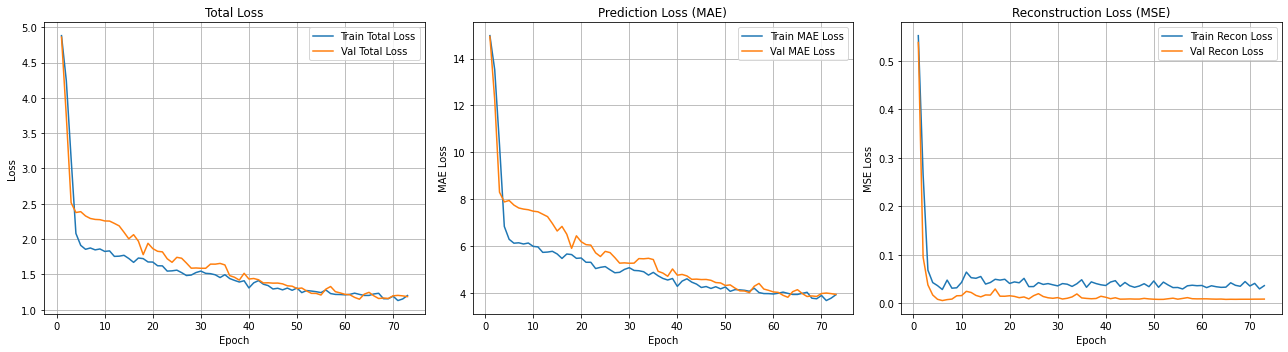

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(train_metrics, val_metrics):

    # Unpack metrics
    train_total, train_pred, train_recon = zip(*train_metrics)
    val_total, val_pred, val_recon = zip(*val_metrics)

    epochs = range(1, len(train_total) + 1)

    plt.figure(figsize=(18, 5))

    # --------------------------------------------------
    # 1) TOTAL LOSS
    # --------------------------------------------------
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_total, label='Train Total Loss')
    plt.plot(epochs, val_total, label='Val Total Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Total Loss")
    plt.grid(True)
    plt.legend()

    # --------------------------------------------------
    # 2) PREDICTION LOSS (MAE)
    # --------------------------------------------------
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_pred, label='Train MAE Loss')
    plt.plot(epochs, val_pred, label='Val MAE Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MAE Loss")
    plt.title("Prediction Loss (MAE)")
    plt.grid(True)
    plt.legend()

    # --------------------------------------------------
    # 3) RECONSTRUCTION LOSS (MSE)
    # --------------------------------------------------
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_recon, label='Train Recon Loss')
    plt.plot(epochs, val_recon, label='Val Recon Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Reconstruction Loss (MSE)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# CALL THE FUNCTION
plot_training_metrics(train_metrics, val_metrics)


### Test

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for noisy_wave, clean_wave, label, weight, pid in test_loader:

            noisy_wave = noisy_wave.to(device)
            label = label.to(device).unsqueeze(1)

            outputs = model(noisy_wave)

            # model returns (prediction, attention, denoised_signal)
            pred = outputs[0]   # FIRST element is the prediction

            preds.append(pred.cpu().numpy())
            targets.append(label.cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    mae = np.mean(np.abs(preds - targets))
    mse = np.mean((preds - targets)**2)
    huber = np.mean(
        np.where(np.abs(preds - targets) < 1,
                 0.5 * (preds - targets)**2,
                 np.abs(preds - targets) - 0.5)
    )

    return mae, mse, huber


In [ ]:
def evaluate_model_per_participant(model, test_loader, device):
    model.eval()
    mse_fn = nn.MSELoss()
    huber_fn = nn.SmoothL1Loss(reduction="mean")

    total_mse = 0
    total_mae = 0
    total_huber = 0
    total_samples = 0

    preds_by_participant = defaultdict(list)
    labels_by_participant = defaultdict(list)

    with torch.no_grad():
        for noisy_wave, clean_wave, labels, weight, participant_ids in test_loader:

            noisy_wave = noisy_wave.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(noisy_wave)
            pred = outputs[0]  # FIRST element: prediction

            batch_size = noisy_wave.size(0)
            total_samples += batch_size

            total_mse += mse_fn(pred, labels).item() * batch_size
            total_mae += F.l1_loss(pred, labels, reduction="sum").item()
            total_huber += huber_fn(pred, labels).item() * batch_size

            for i, pid in enumerate(participant_ids):
                pid = pid.item() if torch.is_tensor(pid) else pid
                preds_by_participant[pid].append(pred[i].item())
                labels_by_participant[pid].append(labels[i].item())

    total_mse /= total_samples
    total_mae /= total_samples
    total_huber /= total_samples

    print("\n===== Per-Participant Evaluation =====")
    print(f"MAE:   {total_mae:.4f}")
    print(f"MSE:   {total_mse:.4f}")
    print(f"RMSE:  {total_mse**0.5:.4f}")
    print(f"Huber: {total_huber:.4f}")

    return preds_by_participant, labels_by_participant



===== Per-Participant Evaluation =====
MAE:   4.4271
MSE:   36.8519
RMSE:  6.0706
Huber: 3.9732


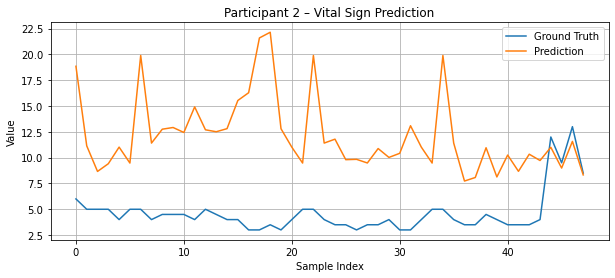

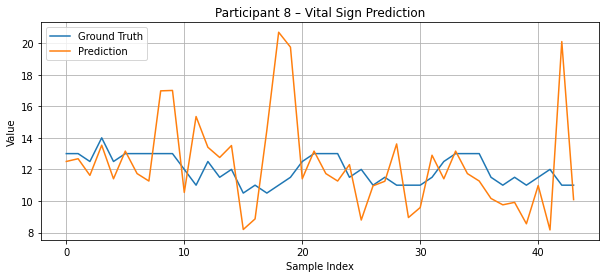

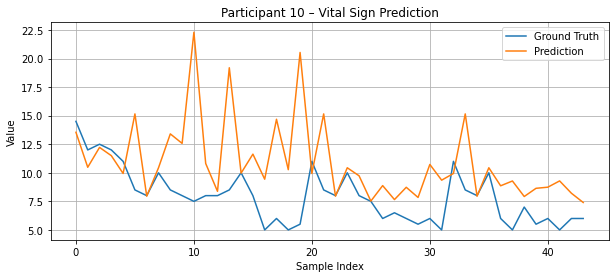

In [ ]:
mae, mse, huber = evaluate_model(model, test_loader, device)

preds_by_participant, labels_by_participant = evaluate_model_per_participant(
    model, test_loader, device
)

plot_participant_predictions(preds_by_participant, labels_by_participant)


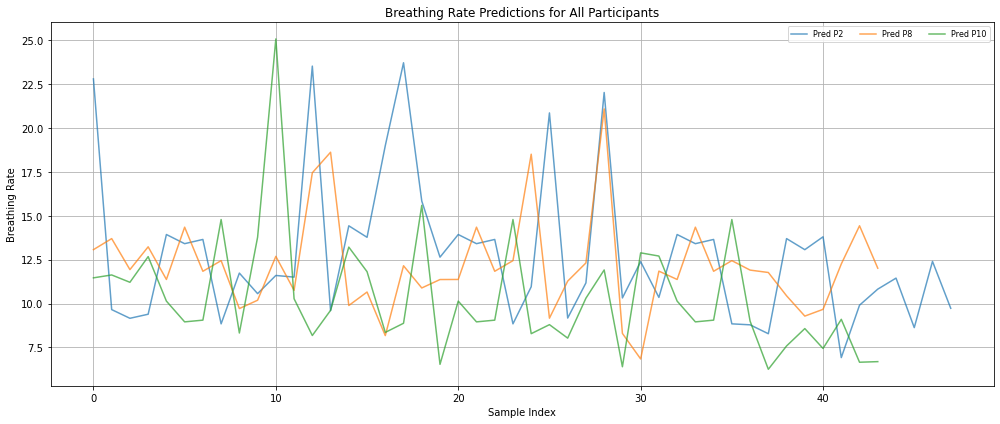

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

for pid in sorted(preds_by_participant.keys()):
    preds = preds_by_participant[pid]
    labels = labels_by_participant[pid]

    # Plot predictions
    plt.plot(preds, label=f'Pred P{pid}', alpha=0.7)

    # OPTIONAL: plot ground truth too (comment out if too messy)
    # plt.plot(labels, label=f'GT P{pid}', alpha=0.7, linestyle='--')

plt.title("Breathing Rate Predictions for All Participants")
plt.xlabel("Sample Index")
plt.ylabel("Breathing Rate")
plt.legend(ncol=3, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


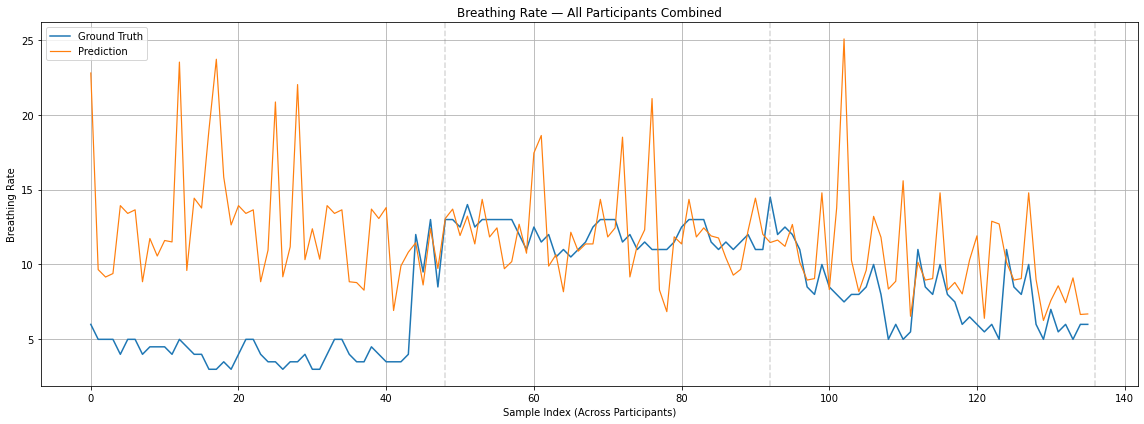

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []
participant_boundaries = []

current_index = 0

# Concatenate all participants in sorted order
for pid in sorted(preds_by_participant.keys()):
    preds = np.array(preds_by_participant[pid])
    labels = np.array(labels_by_participant[pid])

    all_preds.append(preds)
    all_labels.append(labels)

    # Record boundary for marking participant separation
    participant_boundaries.append(current_index + len(preds))
    current_index += len(preds)

# Convert to single long arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# ---- Plot ----
plt.figure(figsize=(16,6))
plt.plot(all_labels, label="Ground Truth", linewidth=1.5)
plt.plot(all_preds, label="Prediction", linewidth=1.2)

# Draw vertical lines to show boundaries between participants
for boundary in participant_boundaries:
    plt.axvline(boundary, color="gray", linestyle="--", alpha=0.3)

plt.title("Breathing Rate — All Participants Combined")
plt.xlabel("Sample Index (Across Participants)")
plt.ylabel("Breathing Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Breathing Rate')

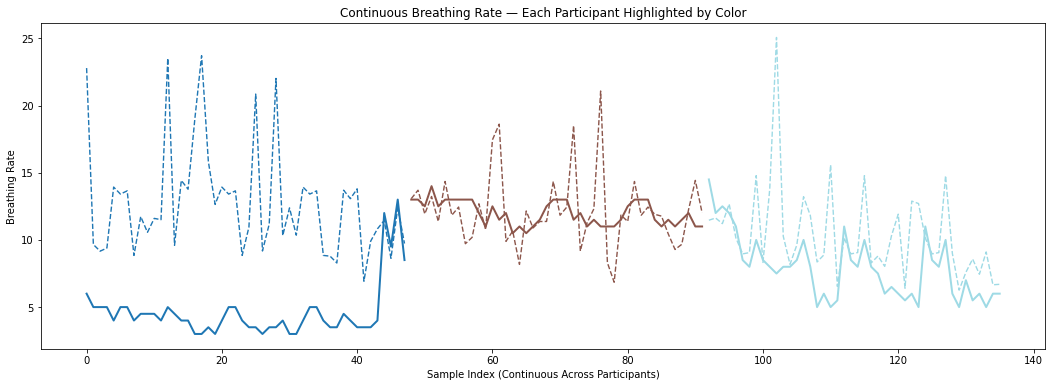

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare lists
all_preds = []
all_labels = []
participant_segments = []   # (start, end, pid)

current_index = 0

# Color map (auto generates enough colors)
cmap = plt.cm.get_cmap('tab20', len(preds_by_participant))

# Build continuous arrays + segment boundaries
for i, pid in enumerate(sorted(preds_by_participant.keys())):
    preds = np.array(preds_by_participant[pid])
    labels = np.array(labels_by_participant[pid])

    start = current_index
    end = current_index + len(preds)

    participant_segments.append((start, end, pid, i))  # store color index

    all_preds.append(preds)
    all_labels.append(labels)

    current_index = end

# Convert to long vectors
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# ---- Plot ----
plt.figure(figsize=(18,6))

for (start, end, pid, col_index) in participant_segments:
    color = cmap(col_index)

    # Plot each participant's GT
    plt.plot(range(start, end),
             all_labels[start:end],
             color=color,
             label=f"P{pid} GT" if col_index == 0 else None,  # avoid repeated legends
             linewidth=2)

    # Plot each participant's Predictions
    plt.plot(range(start, end),
             all_preds[start:end],
             color=color,
             linestyle='--',
             label=f"P{pid} Pred" if col_index == 0 else None,
             linewidth=1.4)

plt.title("Continuous Breathing Rate — Each Participant Highlighted by Color")
plt.xlabel("Sample Index (Continuous Across Participants)")
plt.ylabel("Breathing Rate")


In [ ]:
import torch

all_preds = []
all_labels = []

for pid in preds_by_participant:
    all_preds.extend(preds_by_participant[pid])
    all_labels.extend(labels_by_participant[pid])

all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)

# Calculate global bias
bias = torch.mean(all_preds - all_labels).item()
print("Global Bias:", bias)

# Apply correction
corrected_preds = all_preds - bias


Global Bias: 3.723241090774536


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import matplotlib.pyplot as plt

def evaluate_with_bias_correction(model, test_loader, device):
    model.eval()
    criterion_mse = nn.MSELoss(reduction='none')
    criterion_mae = nn.L1Loss(reduction='none')
    criterion_huber = nn.SmoothL1Loss(reduction='none')

    preds_by_participant = defaultdict(list)
    labels_by_participant = defaultdict(list)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for noisy_wave, clean_wave, labels, weight, participant_ids in test_loader:

            noisy_wave = noisy_wave.to(device)
            labels = labels.to(device).unsqueeze(1)

            # model returns: (prediction, attention, denoised_signal)
            outputs = model(noisy_wave)
            preds = outputs[0]   # FIRST output = prediction

            preds_cpu = preds.cpu().flatten()
            labels_cpu = labels.cpu().flatten()

            all_preds.append(preds_cpu)
            all_labels.append(labels_cpu)

            # store per participant
            for i, pid in enumerate(participant_ids):
                pid = pid.item() if torch.is_tensor(pid) else pid
                preds_by_participant[pid].append(preds_cpu[i].item())
                labels_by_participant[pid].append(labels_cpu[i].item())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ---------- Global Bias ----------
    global_bias = (all_preds - all_labels).mean().item()
    print(f"\nGlobal Bias (mean prediction error): {global_bias:.4f}")

    corrected_preds = all_preds - global_bias

    # ---------- Metrics Before Correction ----------
    mse_before = criterion_mse(all_preds, all_labels).mean().item()
    mae_before = criterion_mae(all_preds, all_labels).mean().item()
    huber_before = criterion_huber(all_preds, all_labels).mean().item()

    # ---------- Metrics After Correction ----------
    mse_after = criterion_mse(corrected_preds, all_labels).mean().item()
    mae_after = criterion_mae(corrected_preds, all_labels).mean().item()
    huber_after = criterion_huber(corrected_preds, all_labels).mean().item()

    print(f"Before correction - MSE: {mse_before:.4f}, MAE: {mae_before:.4f}, Huber: {huber_before:.4f}")
    print(f"After correction  - MSE: {mse_after:.4f}, MAE: {mae_after:.4f}, Huber: {huber_after:.4f}")

    # ---------- Per Participant Metrics ----------
    metrics_per_participant = {}

    for pid in preds_by_participant:
        preds = torch.tensor(preds_by_participant[pid])
        labels = torch.tensor(labels_by_participant[pid])

        mse_b = criterion_mse(preds, labels).mean().item()
        mae_b = criterion_mae(preds, labels).mean().item()
        huber_b = criterion_huber(preds, labels).mean().item()

        corrected_preds_pid = preds - global_bias

        mse_a = criterion_mse(corrected_preds_pid, labels).mean().item()
        mae_a = criterion_mae(corrected_preds_pid, labels).mean().item()
        huber_a = criterion_huber(corrected_preds_pid, labels).mean().item()

        metrics_per_participant[pid] = {
            "MSE_before": mse_b,
            "MAE_before": mae_b,
            "Huber_before": huber_b,
            "MSE_after": mse_a,
            "MAE_after": mae_a,
            "Huber_after": huber_a,
            "preds_before": preds,
            "preds_after": corrected_preds_pid,
            "labels": labels
        }

    # ---------- Plot ----------
    for pid, metrics in metrics_per_participant.items():
        plt.figure(figsize=(15, 5))
        plt.plot(metrics["labels"].numpy(), label="Ground Truth", color='#2078b4')
        plt.plot(metrics["preds_after"].numpy(), label="Prediction (After correction)", color='#ff8012', alpha=0.8)
        plt.title(f"Ground Truth vs Predicted Breathing Rate – Participant {pid}")
        plt.xlabel("Sample Index")
        plt.ylabel("Breathing Rate (bpm)")
        plt.legend()
        plt.grid(True)
        plt.show()

    overall_before = {"MSE": mse_before, "MAE": mae_before, "Huber": huber_before}
    overall_after = {"MSE": mse_after, "MAE": mae_after, "Huber": huber_after}

    return overall_before, overall_after, metrics_per_participant, global_bias



Global Bias (mean prediction error): 3.7232
Before correction - MSE: 39.5019, MAE: 4.3869, Huber: 3.9263
After correction  - MSE: 25.6393, MAE: 4.0883, Huber: 3.6042


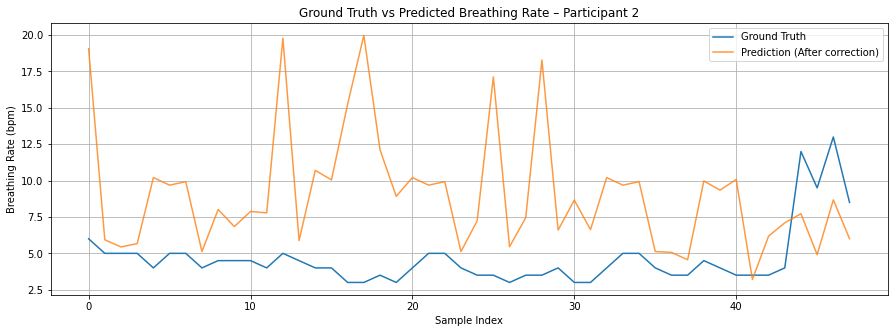

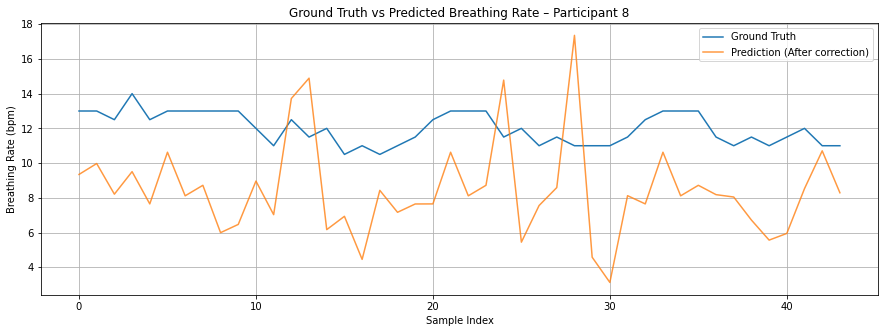

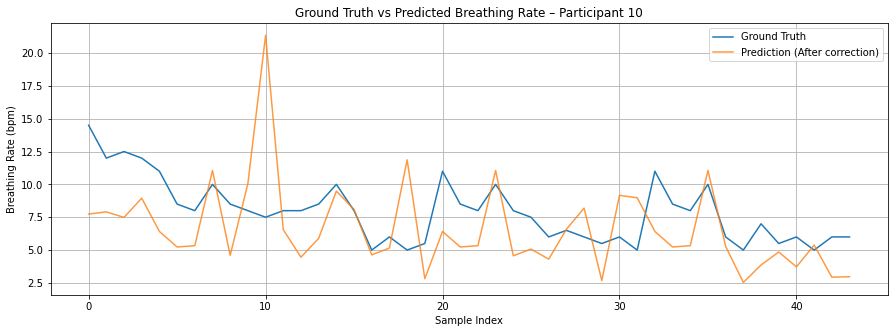

In [ ]:
overall_before, overall_after, per_participant_metrics, bias = evaluate_with_bias_correction(model, test_loader, device)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

def save_metrics_to_csv(
        overall_mae, overall_mse, overall_huber,
        preds_by_participant, labels_by_participant,
        csv_path="evaluation_metrics.csv"
    ):

    # ---- Overall metrics ----
    overall_metrics = {
        "MAE": [overall_mae],
        "MSE": [overall_mse],
        "RMSE": [np.sqrt(overall_mse)],
        "Huber": [overall_huber]
    }
    df_overall = pd.DataFrame(overall_metrics)
    df_overall.to_csv("overall_metrics.csv", index=False)

    # ---- Per-participant metrics ----
    rows = []
    for pid in preds_by_participant:
        preds = np.array(preds_by_participant[pid])
        gts   = np.array(labels_by_participant[pid])

        mae = np.mean(np.abs(preds - gts))
        mse = np.mean((preds - gts)**2)
        rmse = np.sqrt(mse)

        rows.append({
            "Participant": pid,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

    df_participants = pd.DataFrame(rows)
    df_participants.to_csv("per_participant_metrics.csv", index=False)

    print("Saved:")
    print(" - overall_metrics.csv")
    print(" - per_participant_metrics.csv")

    return df_overall, df_participants


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(preds, gts, title="Bland–Altman Plot"):
    preds = np.array(preds)
    gts   = np.array(gts)

    mean_values = (preds + gts) / 2
    diff_values = preds - gts

    mean_bias = np.mean(diff_values)
    sd = np.std(diff_values)

    plt.figure(figsize=(7,5))
    plt.scatter(mean_values, diff_values, alpha=0.5)
    plt.axhline(mean_bias, color='red', linestyle='--', label=f"Mean Bias = {mean_bias:.2f}")
    plt.axhline(mean_bias + 1.96*sd, color='gray', linestyle='--', label="+1.96 SD")
    plt.axhline(mean_bias - 1.96*sd, color='gray', linestyle='--', label="-1.96 SD")

    plt.title(title)
    plt.xlabel("Mean of GT and Prediction")
    plt.ylabel("Difference (Prediction - GT)")
    plt.legend()
    plt.grid(True)
    plt.show()
def bland_altman_per_participant(preds_by_participant, labels_by_participant):
    for pid in sorted(preds_by_participant.keys()):
        preds = preds_by_participant[pid]
        gts   = labels_by_participant[pid]

        bland_altman_plot(
            preds,
            gts,
            title=f"Bland–Altman Plot — Participant {pid}"
        )



===== Per-Participant Evaluation =====
MAE:   4.3345
MSE:   37.5552
RMSE:  6.1282
Huber: 3.8635
Saved:
 - overall_metrics.csv
 - per_participant_metrics.csv


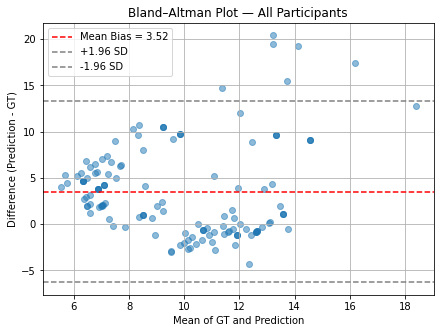

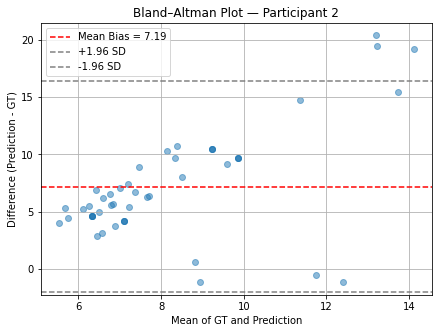

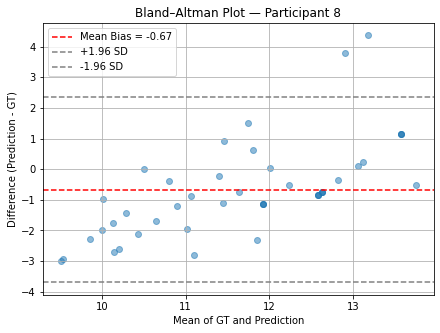

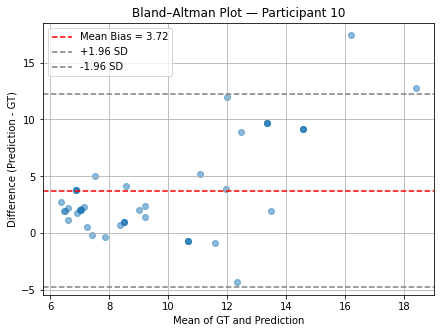

In [ ]:
# ---- Perform evaluation ----
overall_mae, overall_mse, overall_huber = evaluate_model(model, test_loader, device)

preds_by_participant, labels_by_participant = evaluate_model_per_participant(
    model, test_loader, device
)

# ---- Export metrics ----
save_metrics_to_csv(
    overall_mae, overall_mse, overall_huber,
    preds_by_participant, labels_by_participant
)

# ---- Bland–Altman overall ----
all_preds = [p for plist in preds_by_participant.values() for p in plist]
all_gts   = [g for glist in labels_by_participant.values() for g in glist]

bland_altman_plot(all_preds, all_gts, title="Bland–Altman Plot — All Participants")

# ---- Bland–Altman per participant ----
bland_altman_per_participant(preds_by_participant, labels_by_participant)
